# Notebook for Feature Engineering

## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
from skimage import feature
import colorsys
import os
import random
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision import transforms
from pytorch_model_summary import summary

## Feature Extraction

### RGB and HSV features
Use average and variance of 3 channels as features

In [5]:
# takes dataset and feature dictionaries as input
# gets the mean and variance of each hsv channel
def extract_rgb_features(img):
    channel_mean = img.mean(axis=(0,1))
    channel_var = img.var(axis=(0,1))
    return np.append(channel_mean, channel_var)

# takes dataset and feature dictionaries as input
# gets the mean and variance of each hsv channel
def extract_hsv_features(img):
    img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channel_mean = img_convert.mean(axis=(0,1))
    channel_var = img_convert.var(axis=(0,1))
    return np.append(channel_mean, channel_var)


### HOG vector

In [6]:
def extract_grayscale_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # hog = cv2.HOGDescriptor(img_gray.shape, block_size, block_stride, cell_size, num_bins)
    hog = feature.hog(img_gray, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_redchannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_red = img[:,:,2]
    hog = feature.hog(img_red, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_greenchannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_green = img[:,:,1]
    hog = feature.hog(img_green, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_bluechannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_blue = img[:,:,0]
    hog = feature.hog(img_blue, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_huechannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,0]
    hog = feature.hog(img_hue, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_saturationchannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_sat = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,1]
    hog = feature.hog(img_sat, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

def extract_brightnesschannel_hog_features(
        img, 
        cell_size=(20,20),
        block_size=(20,20),
        block_stride=(20,20),
        num_bins=10):
    
    img_val = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2]
    hog = feature.hog(img_val, orientations=num_bins, pixels_per_cell=cell_size, cells_per_block=block_size)
    return hog

In [7]:
def retype_image(in_img):
    if np.max(in_img) > 1:
        in_img = in_img.astype(np.uint8)
    else:
        in_img = (in_img * 255.0).astype(np.uint8)
    return in_img

class ResNet:
    """ """

    def __init__(self) -> None:
        self.model_weights = ResNet101_Weights.IMAGENET1K_V2
        model = resnet101(weights=self.model_weights)
        # remove classification layer
        self.model = nn.Sequential(*list(model.children())[:-1])
        self.model.eval()
        self.preprocess = self.model_weights.transforms()

    def preprocess_im(self, im):
        """ """
        im = retype_image(im)
        return self.preprocess(Image.fromarray(im))

    def process_im(self, im):
        """ """
        im = self.preprocess_im(im=im)
        im = im.unsqueeze(0).to("cpu")
        output = self.model(im).squeeze()
        return output.detach().numpy()

def apply_resnet(im):
    model = ResNet()
    return model.process_im(im=im)

### Dataset Load Function
Takes in list of feature functions and applies them within the load loop to save resources

In [8]:
# dataset info
def load_dataset(data_dir, feature_functions={}, cl_limit=30, img_limit=220):
    X = []
    Y = []
    idx_to_cl = {}
    features = []
    features_idxs = {}

    for i, cl in enumerate(os.listdir(data_dir)):
        if i >= cl_limit:
            break

        print(cl)
        idx_to_cl[i] = cl
        for j, fname in tqdm(enumerate(os.listdir(os.path.join(data_dir,cl)))):
            if j >= img_limit:
                break
            
            img = cv2.imread(os.path.join(data_dir, cl, fname))
            X.append(img)
            Y.append(i)

            feature = np.array([])
            for function_name in feature_functions.keys():
                start = len(feature)
                feature = np.append(feature, feature_functions[function_name](img))
                # start of feature is length before appending, end of feature is length -1 after appending
                features_idxs[function_name] = (start, len(feature) - 1)
            features.append(feature)
            
    return np.array(X), np.array(Y), idx_to_cl, np.array(features), features_idxs


In [9]:
# dataset info
def load_dataset_no_features(data_dir, cl_limit=30, img_limit=220):
    X = []
    Y = []
    idx_to_cl = {}

    for i, cl in enumerate(os.listdir(data_dir)):
        if i >= cl_limit:
            break

        print(cl)
        idx_to_cl[i] = cl
        for j, fname in tqdm(enumerate(os.listdir(os.path.join(data_dir,cl)))):
            if j >= img_limit:
                break
            
            img = cv2.imread(os.path.join(data_dir, cl, fname))
            X.append(img)
            Y.append(i)
            
    return np.array(X), np.array(Y), idx_to_cl

def apply_features(X, feature_functions={}):
    features = []
    features_idxs = {}
    for img in tqdm(X):
        feature = np.array([])
        for function_name in feature_functions.keys():
            start = len(feature)
            feature = np.append(feature, feature_functions[function_name](img))
            features_idxs[function_name] = (start, len(feature) - 1)
        features.append(feature)
    return np.array(features), features_idxs

In [ ]:
# # # # # # # # # # # # # # 
feature_folder_name = "rgb_hsv"
# # # # # # # # # # # # # #

In [10]:
# call load_dataset_no_features to get entire X, Y
# then we do train_test_split to get X_train, X_test, Y_train, Y_test
# finally, apply features to X_train only

X, Y, idx_to_cl = load_dataset_no_features('data') # load 30 classes, 220 images per class
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True, random_state=42) # train test split at 80-20 ratio

# save all to npy files
with open('train_test_data/{}/X_train.npy'.format(feature_folder_name), 'wb') as f:
    np.save(f, X_train)
with open('train_test_data/{}/X_test.npy'.format(feature_folder_name), 'wb') as f:
    np.save(f, X_test)
with open('train_test_data/{}/Y_train.npy'.format(feature_folder_name), 'wb') as f:
    np.save(f, Y_train)
with open('train_test_data/{}/Y_test.npy'.format(feature_folder_name), 'wb') as f:
    np.save(f, Y_test)


Airport


220it [00:01, 138.40it/s]


BareLand


220it [00:01, 134.37it/s]


BaseballField


220it [00:01, 148.93it/s]


Beach


220it [00:01, 181.34it/s]


Bridge


220it [00:01, 157.37it/s]


Center


220it [00:01, 125.37it/s]


Church


220it [00:01, 176.21it/s]


Commercial


220it [00:01, 147.65it/s]


DenseResidential


220it [00:01, 147.44it/s]


Desert


220it [00:01, 158.11it/s]


Farmland


220it [00:01, 182.48it/s]


Forest


220it [00:01, 149.71it/s]


Industrial


220it [00:01, 157.89it/s]


Meadow


220it [00:01, 169.19it/s]


MediumResidential


220it [00:01, 125.12it/s]


Mountain


220it [00:01, 179.84it/s]


Park


220it [00:01, 148.86it/s]


Parking


220it [00:01, 139.16it/s]


Playground


220it [00:01, 178.23it/s]


Pond


220it [00:01, 200.61it/s]


Port


220it [00:01, 197.37it/s]


RailwayStation


220it [00:01, 148.22it/s]


Resort


220it [00:01, 151.16it/s]


River


220it [00:01, 187.75it/s]


School


220it [00:01, 138.22it/s]


SparseResidential


220it [00:01, 113.92it/s]


Square


220it [00:01, 129.35it/s]


Stadium


220it [00:01, 134.36it/s]


StorageTanks


220it [00:01, 133.86it/s]


Viaduct


220it [00:01, 166.40it/s]


In [11]:
# now we can do feature extraction based on experiments while keeping training and test data consistent

# rgb and hsv experiment features
rgb_hsv_experiment, features_idxs = apply_features(X_train, feature_functions={
    'rgb':extract_rgb_features,
    'hsv':extract_hsv_features
})

# # hog features
# gray_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'gray_hog':extract_grayscale_hog_features,
# })

# red_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'red_hog':extract_redchannel_hog_features,
# })

# green_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'green_hog':extract_greenchannel_hog_features,
# })

# blue_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'blue_hog':extract_bluechannel_hog_features,
# })

# hue_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'hue_hog':extract_huechannel_hog_features,
# })

# saturation_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'saturation_hog':extract_saturationchannel_hog_features,
# })

# brightness_hog_experiment, feature_idxs = apply_features(X_train, feature_functions={
#     'brightness_hog':extract_brightnesschannel_hog_features,
# })

# # deep learning features
# # TODO

# # combined features
# # first method
# multiple_features, feature_idxs = apply_features(X_train, feature_function={
#     'rgb':extract_rgb_features,
#     'hsv':extract_hsv_features,
#     'gray_hog':extract_grayscale_hog_features,
#     'hue_hog':extract_huechannel_hog_features,
#     # deep learning features ...
# })

In [12]:
# features scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(rgb_hsv_experiment) # replace input with whatever experiments we are doing
# TODO: save this scaler for final features only

### PCA (optional)

In [53]:
# PCA for features, use 95% explained variance for now
pca = PCA(n_components=0.95)
train_transformed = pca.fit_transform(features_train_scaled)
print(train_transformed.shape)

# TODO: save this pca model for final features

(4662, 9000)
(4662, 2528)
(1998, 2528)


## Feature visualizations

### RGB and HSV histograms

In [10]:
def rgb_hist(rgb_imgs, y_labels, idx_to_cl, write_path='plots/histograms/'):
    labels = [idx_to_cl[idx] for idx in y_labels]

    # imgs are shape (n_images, 600, 600, 3)
    avgs = pd.DataFrame(np.mean(rgb_imgs, axis=(1,2)), columns=['Blue', 'Green', 'Red'])
    vars = pd.DataFrame(np.var(rgb_imgs, axis=(1,2)), columns=['Blue', 'Green', 'Red'])
    avgs['Class'] = labels
    vars['Class'] = labels

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
    for i,color in enumerate(['Blue', 'Green', 'Red']):
        sns.kdeplot(data=avgs, x=color, hue='Class', ax=axs[0,i])
        axs[0,i].set_title(f'Mean Value for {color} Channel')
        sns.kdeplot(data=vars, x=color, hue='Class', ax=axs[1,i])
        axs[0,i].set_title(f'Variance of {color} Channel')
    
    plt.savefig(write_path+'rgb_histograms.png')
    plt.show()
    
    return avgs, vars
    

In [11]:
def hsv_hist(rgb_imgs, y_labels, idx_to_cl, write_path='plots/histograms/'):
    # convert bgr to hsv
    hsv_imgs = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in rgb_imgs])

    labels = [idx_to_cl[idx] for idx in y_labels]

    # imgs are shape (n_images, 600, 600, 3)
    avgs = pd.DataFrame(np.mean(hsv_imgs, axis=(1,2)), columns=['Hue', 'Saturation', 'Brightness'])
    vars = pd.DataFrame(np.var(hsv_imgs, axis=(1,2)), columns=['Hue', 'Saturation', 'Brightness'])
    avgs['Class'] = labels
    vars['Class'] = labels

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
    for i,color in enumerate(['Hue', 'Saturation', 'Brightness']):
        sns.kdeplot(data=avgs, x=color, hue='Class', ax=axs[0,i])
        axs[0,i].set_title(f'Mean Value for {color} Channel')
        sns.kdeplot(data=vars, x=color, hue='Class', ax=axs[1,i])
        axs[0,i].set_title(f'Variance of {color} Channel')
    
    plt.savefig(write_path+'hsv_histograms.png')
    plt.show()

    return avgs, vars

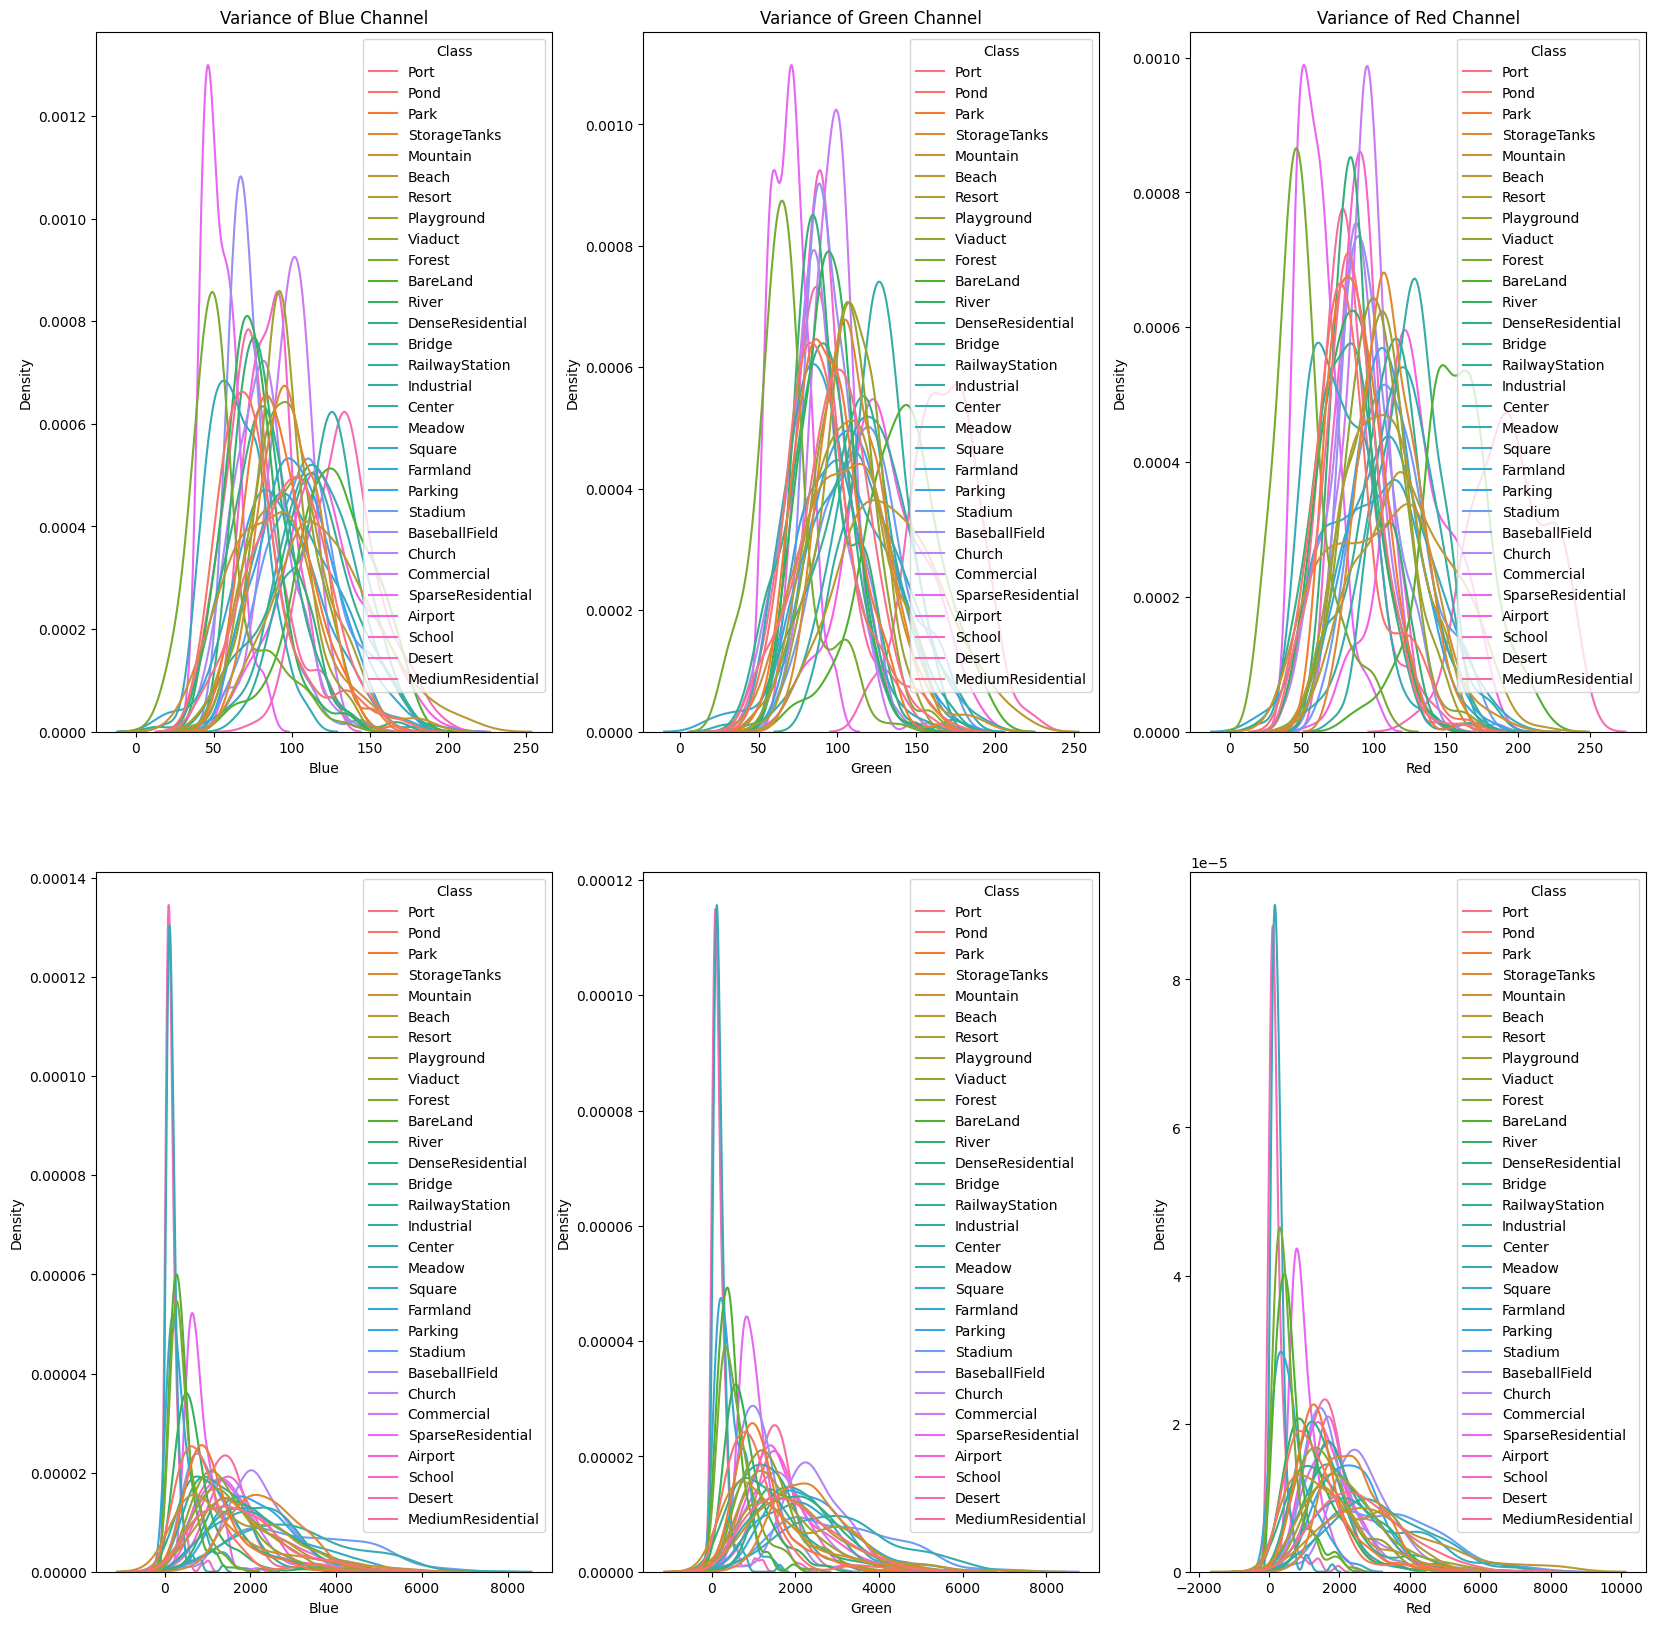

In [15]:
avgs, vars = rgb_hist(X_train, Y_train, idx_to_cl, write_path='plots/histograms/')

### HOG plots

In [ ]:
# generate 7 hog images, one for each rgb channel, hsv channel. and one grayscale 
def hog_plots(rgb_img, path='plots/hog/', prefix='sample'):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2HSV) # shape: (600, 600, 3)
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY) # shape: (600, 600)

    # rgb hog plots
    for i, channel in enumerate(['blue','green','red']):
        (_, hog_img) = feature.hog(rgb_img[:,:,i], orientations=10, pixels_per_cell=(20,20), cells_per_block=(20,20),visualize=True)
        cv2.imwrite(f'{path}{prefix}_{channel}.jpg', hog_img*255)

    # hsv hog plots
    for i, channel in enumerate(['hue','saturation','brightness']):
        (_, hog_img) = feature.hog(hsv_img[:,:,i], orientations=10, pixels_per_cell=(20,20), cells_per_block=(20,20),visualize=True)
        cv2.imwrite(f'{path}{prefix}_{channel}.jpg', hog_img*255)

    # grayscale hog plot
    (_, hog_img) = feature.hog(grayscale_img, orientations=10, pixels_per_cell=(20,20), cells_per_block=(20,20),visualize=True)
    cv2.imwrite(f'{path}{prefix}_grayscale.jpg', hog_img*255)


### PCA line plot
PCA explained variance plot using a multitude of feature combinations

In [ ]:
# takes in list of np array features of shape (n_images, m_feature_length)
# plot explained variance for each feature, as well as an optional all features combined
def pca_plot(features_dict, max_components=500, include_all_features=True, path='plots/pca/'):
    df_pca = pd.DataFrame(columns=['n_components','explained_variance','feature'])
    for feature in features_dict.keys():
        pca = PCA()
        feature_pca = np.sort(pca.fit_transform(features_dict[feature]).explained_variance_ratio_)[::-1].cumsum()[:max_components]
        tmp = pd.DataFrame({
            'n_components':np.arange(1,len(feature_pca),1),
            'explained_variance':feature_pca,
            'feature':[feature for _ in range(len(feature_pca))]})
        df_pca = pd.concat(df_pca, tmp, axis=0)

    if include_all_features:
        all_features = np.hstack(list(features_dict.values()))
        pca = PCA()
        feature_pca = np.sort(pca.fit_transform(all_features).explained_variance_ratio_)[::-1].cumsum()[:max_components]
        tmp = pd.DataFrame({
            'n_components':np.arange(1,len(feature_pca),1),
            'explained_variance':feature_pca,
            'feature':'All features'})
        df_pca = pd.concat(df_pca, tmp, axis=0)

    fig, ax = plt.subplots(figsize=(20,12))
    sns.lineplot(data=df_pca, x='n_components', y='explained_variance', hue='feature', ax=ax)
    ax.set_xlabel('# of Components')
    ax.set_ylabel('Percent of Explained Variance')
    ax.set_title('PCA Explained Variance for Considered Features')
    fig.savefig(f'{path}explained_variance.png')

    return df_pca


## Model training

### Logistic regression feature selection
Need to manually run for each experiment to select final set of features

In [19]:
lr = LogisticRegression(
    penalty= "l2",
    tol = 1e-4,
    C=1.0,
    solver="lbfgs",
    max_iter=150,
    multi_class="multinomial",
    n_jobs=-1,
)

# replace experiment with whatever feature we are testing
lr_model = cross_validate(lr, features_train_scaled, Y_train, scoring=('f1_weighted','accuracy'), cv=30)

In [27]:
for key, value in lr_model.items():
    print(key)
    print(value)

fit_time
[2.89702392 1.09466124 1.0592804  1.02746177 1.06492448 1.08028507
 1.06405425 1.03643537 1.04125142 1.04883623 1.16117549 1.16185117
 0.56091952 0.52806592 0.57306457 0.52836871 0.51911259 0.49255443
 0.58515143 0.54568315]
score_time
[0.01102328 0.00150776 0.00200915 0.00127983 0.00099921 0.00100589
 0.00199914 0.00199866 0.00099897 0.00115371 0.00200582 0.00200105
 0.00150323 0.00150704 0.00100756 0.00099969 0.00099707 0.00251484
 0.00099897 0.00105309]
test_f1_weighted
[0.3507095  0.40697265 0.35137431 0.44348947 0.42026793 0.41892973
 0.38897852 0.3721081  0.35245369 0.40277192 0.35936617 0.41049272
 0.43559145 0.45779649 0.38501314 0.44502893 0.39467177 0.41243621
 0.39804624 0.36549451]
test_accuracy
[0.37121212 0.4280303  0.38636364 0.46212121 0.43939394 0.43939394
 0.39772727 0.39015152 0.37878788 0.42424242 0.39015152 0.43181818
 0.45454545 0.48106061 0.40909091 0.46969697 0.40909091 0.4469697
 0.41666667 0.39393939]


In [28]:
print('F1 score:',np.mean(lr_model['test_f1_weighted']))

F1 score: 0.3985996733493563


In [29]:
print('Accuracy:',np.mean(lr_model['test_accuracy']))

Accuracy: 0.4210227272727273


### Logistic regression grid search
Use the subsetted training data to plug into the models

In [56]:
lr = LogisticRegression()
lr_params = {
    'penalty':['l1','l2'],
    'tol':[1e-5, 1e-4, 1e-3, 1e-2],
    'C':[0.2, 0.5, 1.0, 1.5, 2],
    'max_iter':[50,100,150,200]
}

lr_model = GridSearchCV(lr, lr_params)
lr_model.fit(pca_features_train, Y_train)
lr_model.score(pca_features_test, Y_test)

# TODO: save final lr model

c:\Users\kdai1\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kdai1\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.4009009009009009

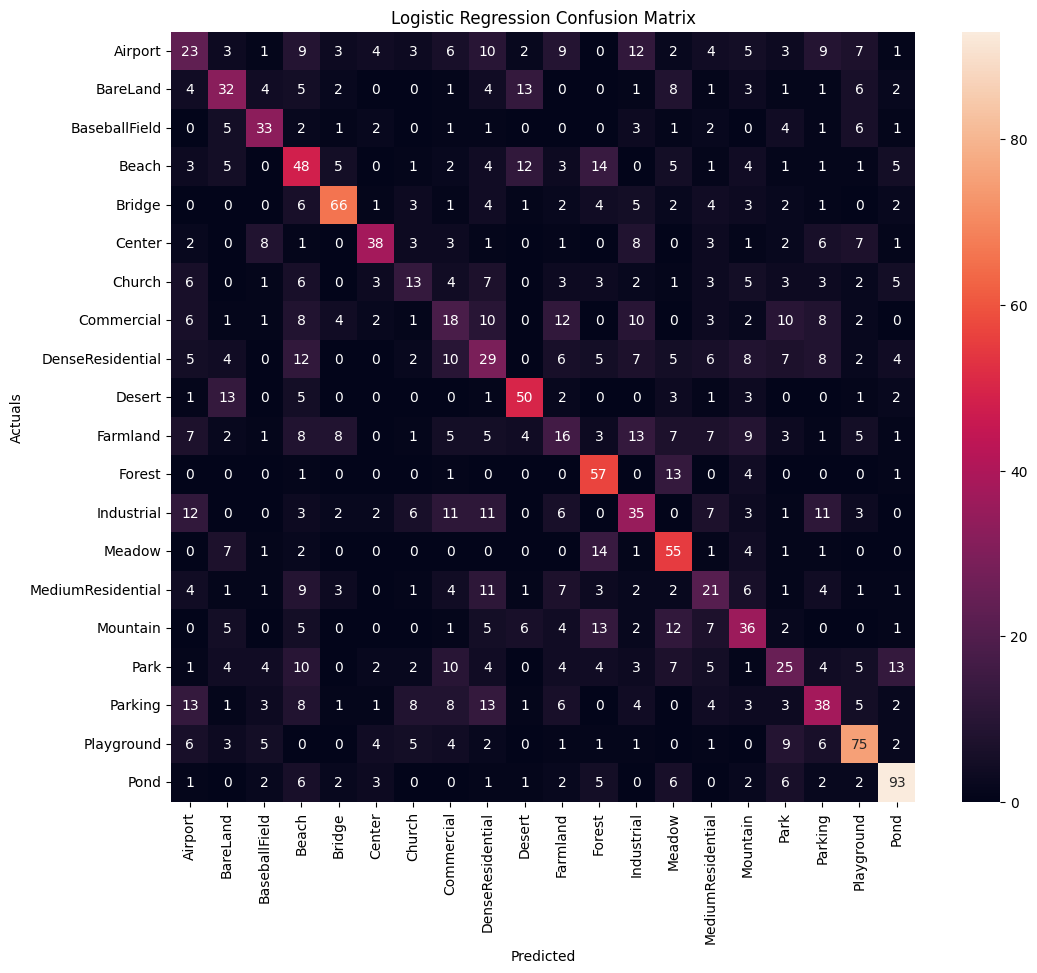

In [57]:
# deriving confusion matrix from Y prediction of test set
Y_pred = lr_model.predict(pca_features_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)
labels = [x for _, x in sorted(zip(idx_to_cl.keys(), idx_to_cl.values()))]
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# plotting confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(conf_df, annot=True)
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actuals')
plt.xlabel('Predicted')
plt.show()

### SVM

In [59]:
# svm = SVC()
# svm_params = {
#     'C':[0.2,0.5,1.0,2.0],
#     'kernel':['linear','poly','rbg','sigmoid'],
#     'degree':[3,5,7,9],
#     'tol':[1e-5, 1e-4, 1e-3, 1e-2]
# }
# svm_model = GridSearchCV(svm, svm_params)
svm_model = SVC()
svm_model.fit(pca_features_train, Y_train)
svm_model.score(pca_features_test, Y_test)

# TODO: save final SVM model

0.3733733733733734

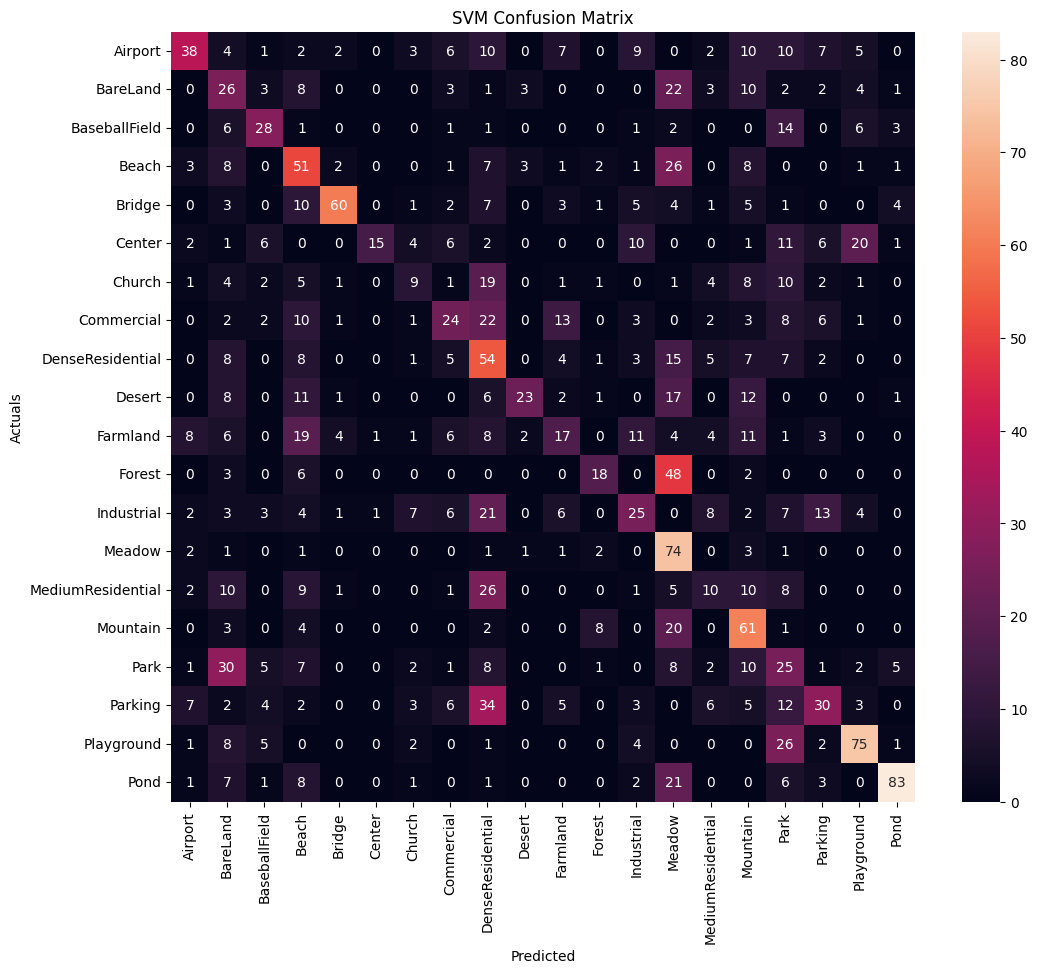

In [60]:
# deriving confusion matrix from Y prediction of test set
Y_pred = svm_model.predict(pca_features_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)
labels = [x for _, x in sorted(zip(idx_to_cl.keys(), idx_to_cl.values()))]
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# plotting confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(conf_df, annot=True)
plt.title('SVM Confusion Matrix')
plt.ylabel('Actuals')
plt.xlabel('Predicted')
plt.show()

## Testing

### Test set feature extraction
ONLY USE THIS AT VERY END

In [ ]:
multiple_features_test, feature_idxs = apply_features(X_test, feature_function={
    'rgb':extract_rgb_features,
    'hsv':extract_hsv_features,
    'gray_hog':extract_grayscale_hog_features,
    'hue_hog':extract_huechannel_hog_features,
    # deep learning features ...
})

In [ ]:
# Test PCA here
# load scaler and PCA model here
features_test_scaled = scaler.transform(X_test) # normalize
pca_test = pca.transform(features_test_scaled) # pca

### Model with test data

In [ ]:
# load models
# run inference on pca_test